In [50]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

df = pd.read_csv(r"C:\Users\ASUS\Documents\Zomato_Review.csv")

In [3]:
# Show basic info and check for missing values
df.info()
# Display basic statistics for numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         500 non-null    int64 
 1   restaurant_id     500 non-null    int64 
 2   user_id           500 non-null    int64 
 3   review_text       500 non-null    object
 4   rating            500 non-null    int64 
 5   review_date       500 non-null    object
 6   user_activity     500 non-null    int64 
 7   review_length     500 non-null    int64 
 8   spam_label        500 non-null    int64 
 9   review_sentiment  500 non-null    object
 10  is_verified       500 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 43.1+ KB


,review_id,restaurant_id,user_id,rating,user_activity,review_length,spam_label,is_verified
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,250.500000,1003.892000,2007.950000,3.430000,7.564000,7.210000,0.294000,0.716000
std,144.481833,2.085434,4.334175,1.346375,2.848532,1.803442,0.456048,0.451388
min,1.000000,1001.000000,2001.000000,1.000000,1.000000,3.000000,0.000000,0.000000
25%,125.750000,1002.000000,2004.000000,2.000000,6.000000,6.000000,0.000000,0.000000
50%,250.500000,1004.000000,2008.000000,3.000000,7.000000,7.000000,0.000000,1.000000
75%,375.250000,1006.000000,2012.000000,5.000000,10.000000,9.000000,1.000000,1.000000
max,500.000000,1007.000000,2015.000000,5.000000,30.000000,10.000000,1.000000,1.000000


<Axes: xlabel='spam_label', ylabel='count'>

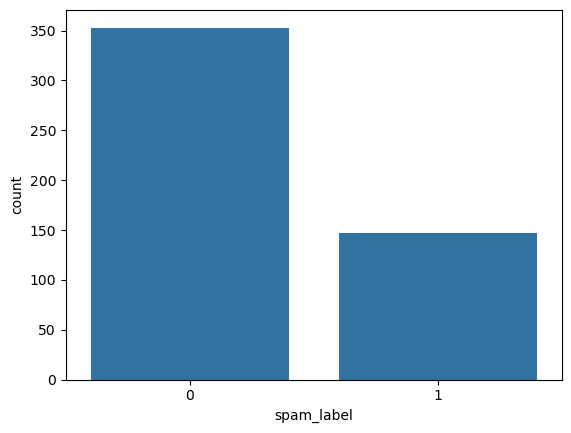

In [5]:
# Check the distribution of spam labels
sns.countplot(x='spam_label', data=df)

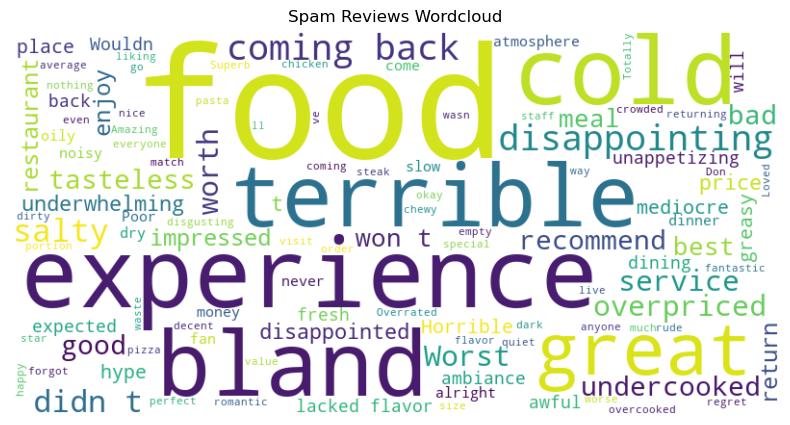

In [7]:
# Wordcloud for review_text to check common words
spam_reviews = df[df['spam_label'] == 1]['review_text']
non_spam_reviews = df[df['spam_label'] == 0]['review_text']

# Combine all spam and non-spam reviews for visualization
spam_text = ' '.join(spam_reviews)
non_spam_text = ' '.join(non_spam_reviews)

# Create WordCloud for Spam Reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Spam Reviews Wordcloud')
plt.axis('off')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Handling missing values (if any)
df = df.dropna()

# Feature engineering: Adding review length and word count
df['review_length'] = df['review_text'].apply(len)
df['word_count'] = df['review_text'].apply(lambda x: len(x.split()))

# Encoding categorical columns like sentiment and verification status
le_sentiment = LabelEncoder()
df['review_sentiment'] = le_sentiment.fit_transform(df['review_sentiment'])

# Split data into features (X) and target (y)
X = df[['review_text', 'rating', 'user_activity', 'review_length', 'word_count', 'review_sentiment', 'is_verified']]
y = df['spam_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# TF-IDF vectorization for the review_text column
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train['review_text'])
X_test_tfidf = tfidf.transform(X_test['review_text'])

# Combine the TF-IDF features with other features like rating, user_activity, etc.
from scipy.sparse import hstack

X_train_final = hstack([X_train_tfidf, X_train.drop('review_text', axis=1).values])
X_test_final = hstack([X_test_tfidf, X_test.drop('review_text', axis=1).values])


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_final)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.98        32

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



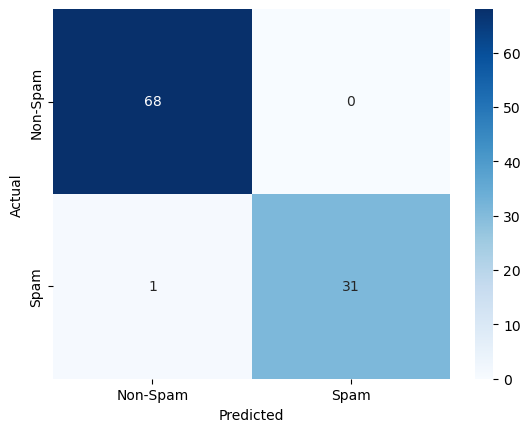

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [21]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_final)

# Evaluate the Random Forest model
print(f"Random Forest - Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest - Accuracy: 0.99
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.98        32

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



In [23]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_final)

# Evaluate the XGBoost model
print(f"XGBoost - Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost - Accuracy: 0.99
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.98        32

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:08:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [27]:
# Evaluate Random Forest
print(f"Random Forest - Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Evaluate XGBoost
print(f"XGBoost - Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Compare the accuracy scores
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")


Random Forest - Accuracy: 0.99
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.98        32

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100

XGBoost - Accuracy: 0.99
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.97      0.98        32

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100

Random Forest Accuracy: 0.99
XGBoost Accuracy: 0.99


IndexError: index 126 is out of bounds for axis 0 with size 6

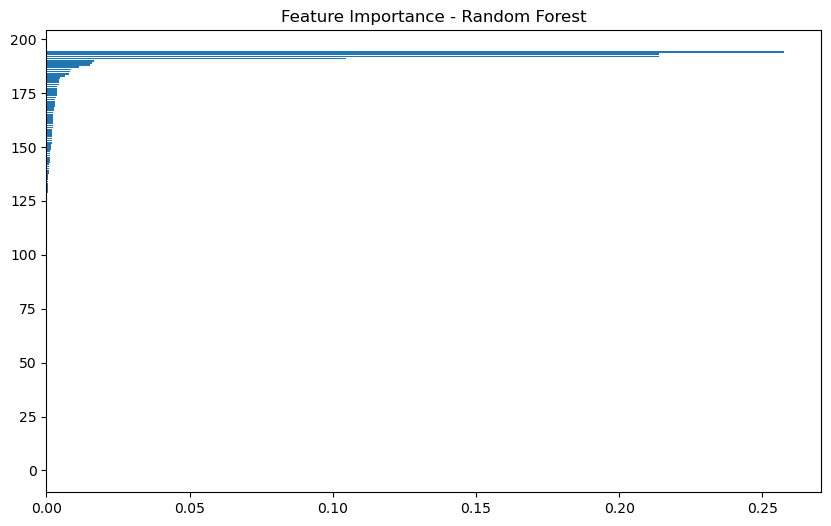

In [37]:
import numpy as np  # Import numpy

import matplotlib.pyplot as plt

# Plot feature importances for Random Forest
importances = rf_model.feature_importances_
features = X_train.drop('review_text', axis=1).columns

# Sorting the importances in descending order
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()


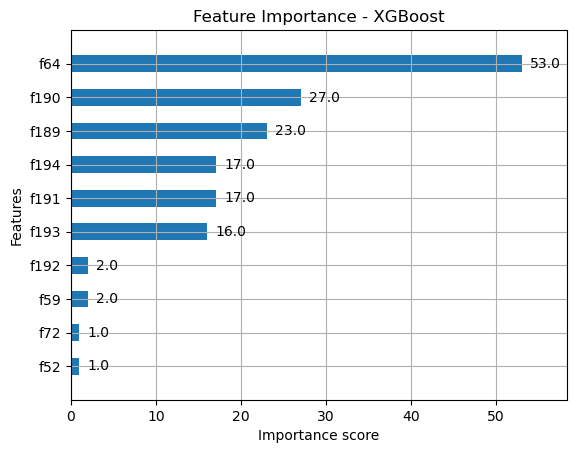

In [31]:
from xgboost import plot_importance

# Plot feature importance for XGBoost
plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title('Feature Importance - XGBoost')
plt.show()
